# Baseline Model for Poker games profitable moves predictor


#### - The data was created in the other Notebook "01_Poker_data_preprocessing.ipynb".
#### - The exploratory data analysis was done in the other Notebook "02_Poker_exploratory_data_analysis.ipynb".


# What models should I use ?

The research question is "Is it possible to predict the most profitable moves to play in a poker game ?"
We expect to build a model to answer the research question. Based on the input data, the model should be able to make 2 predictions:
- What the player's next action should be (fold, check/call, or raise). For each move there is only one of those 3 choices. For this point, we will need a classification model to predict the action
- In case the action predicted is "raise", what should be the best amount to raise to be the most profitable possible. In the other cases when the choice was fold or check/call, there is no need to predict any amount as the player won't need to bet anything. For this point, we will need another regression model to predict the amount to raise

## Loading Libraries

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import confusion_matrix, classification_report
import graphviz
from sklearn.tree import export_graphviz
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.metrics import auc as skl_auc
import matplotlib.pyplot as plt
from phevaluator.evaluator import evaluate_cards
import joblib
import os
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

## Functions

### Function cards_score
This function gets a minimum of 2 cards and a maximum of 7 cards as an input and return a calculated card score. The lower the card score is, the better.
We already had this function in the notebook "01_Poker_data_preprocessing.ipynb"

In [2]:
def cards_score(c1: str, c2: str, c3: str, c4: str, c5: str, c6: str, c7: str):
    """
    This function gets a minimum of 2 cards and a maximum of 7 cards as an input
    and return a calculated card score. The lower the card score is, the better.
    
    Arguments
    ---------
    c1: string
           Card 1
    c2: string
           Card 2
    c3: string
           Card 3
    c4: string
           Card 4
    c5: string
           Card 5
    c6: string
           Card 6
    c7: string
           Card 7

    Returns
    --------
    cards_score_result: float
         Number which represent the strength of the cards analyzed in the input. The lower the number is the stronger the hands of cards are.
    """
    cards_score_result = 0

    if (len(c1) > 0) & (len(c2) > 0) & (len(c3) == 0) & (len(c4) == 0) & (len(c5) == 0) & (len(c6) == 0) & (len(c7) == 0):
        # find a color not in the list of the first 2 cards
        list_colors = ['d', 'h', 's', 'c']
        c1_color = c1[1:2]
        c2_color = c2[1:2]
        list_colors.remove(c1_color)
        if c1_color != c2_color:
            list_colors.remove(c2_color)
        color_pick = list_colors[0]
        # find 3 other small cards to add to the initial 2 cards
        list_cards = ['2', '3', '4', '5', '6', '7']
        temp_cards_score_result = 0
        max_cards_score_result = 0
        for card3 in list_cards:
            for card4 in list_cards:
                for card5 in list_cards:
                    try:
                        temp_cards_score_result = evaluate_cards(c1, c2, card3 + color_pick, card4 + color_pick, card5 + color_pick)
                        if temp_cards_score_result >= max_cards_score_result:
                            max_cards_score_result = temp_cards_score_result
                    except Exception:
                        pass
        cards_score_result = max_cards_score_result
    elif (len(c1) > 0) & (len(c2) > 0) & (len(c3) > 0) & (len(c4) > 0) & (len(c5) > 0) & (len(c6) == 0) & (len(c7) == 0):
        cards_score_result = evaluate_cards(c1, c2, c3, c4, c5)
    elif (len(c1) > 0) & (len(c2) > 0) & (len(c3) > 0) & (len(c4) > 0) & (len(c5) > 0) & (len(c6) > 0) & (len(c7) == 0):
        cards_score_result = evaluate_cards(c1, c2, c3, c4, c5, c6)
    elif (len(c1) > 0) & (len(c2) > 0) & (len(c3) > 0) & (len(c4) > 0) & (len(c5) > 0) & (len(c6) > 0) & (len(c7) > 0):
        cards_score_result = evaluate_cards(c1, c2, c3, c4, c5, c6, c7)
    
    return cards_score_result

## Loading Dataset

In [3]:
# load the data from the CSV file
df = pd.read_csv('data/poker_games.csv')
df.head()

,index,game_id,turn_id,player_id,player_name,stage,sub_stage,stage_int,position_int,position_code_1,...,amount_finish,nb_players_left,nb_previous_raise,nb_straight_player_cards,nb_straight_community_cards,nb_flush_player_cards,nb_flush_community_cards,chen_score,cards_score,pct_score
0,0,100_0,1,p3,MrWhite,preflop,1,1,3,UTG,...,10000.0,6,0,1,0,1,0,0.0,7444,0.000
1,1,100_0,2,p4,MrPink,preflop,1,1,4,MP,...,9790.0,5,0,2,0,2,0,7.0,6678,-0.021
2,2,100_0,3,p5,MrBrown,preflop,1,1,5,CO,...,10000.0,5,0,1,0,1,0,0.0,7410,0.000
3,3,100_0,4,p6,Pluribus,preflop,1,1,6,BTN,...,10000.0,4,0,2,0,1,0,3.5,7461,0.000
4,4,100_0,5,p1,MrBlue,preflop,1,1,1,SB,...,10310.0,3,0,2,0,2,0,9.0,7146,0.031


## Decision Tree classification model to predict the action
For the baseline model, we choose to use a Decision Tree because it is interpretable and can be easily explained. 
Most of the models are difficult to explain to non technical users, and Decision Tree on the other hand is very intuitive to understand.
That is one of the reason I am interested to use a Decision Tree, to communicate to non technical users how this machine learning model works and how it fits in a machine learning project.
Also Decision Tree is a very dynamic machine learning model, as it scales with the data. The bias is low

We saw in the exploratory_data_analysis, that the top 3 features are cards_score, amount_required and chen_score. We will keep only the 2 features cards_score and amount_required as input for a simple baseline model, since the chen_score is a metric a bit redundant from the cards_score.
Also keeping only 2 features will allow us to do more easily some visualizations and plots

In [4]:
# Decision Tree Classification
X = df[['cards_score', 'amount_required']]
y = df['action_int']

# Divide the dataset into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model: Decision Tree
pipelined_model = Pipeline([
    ('dtc', DecisionTreeClassifier(criterion='entropy', max_depth=4))
])
pipelined_model.fit(X_train, y_train)
y_pred = pipelined_model.predict(X_test)
pipelined_model

Pipeline(steps=[('dtc',
                 DecisionTreeClassifier(criterion='entropy', max_depth=4))])

### Performance Metrics
For a multi-class problem, a confusion matrix, a ROC curve and a classification report would be beneficial.

#### Confusion matrix and ROC Curve

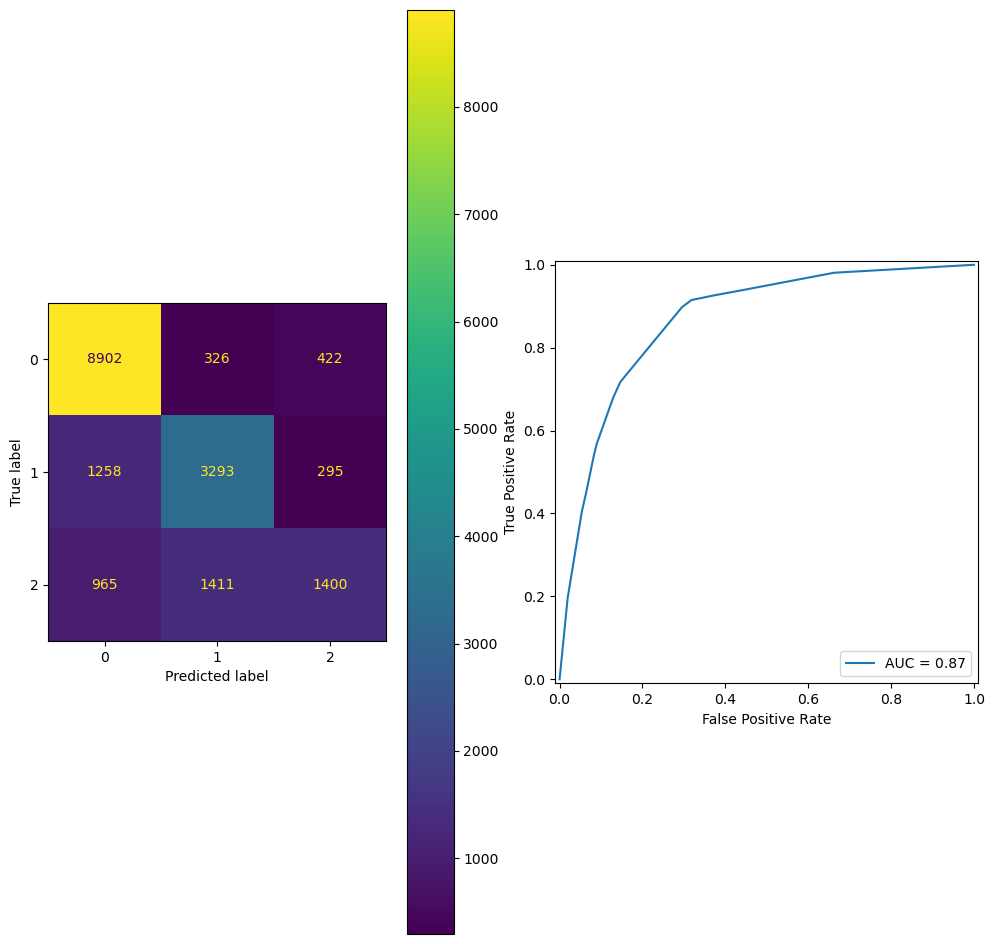

In [5]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 12)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
disp1 = ConfusionMatrixDisplay(conf_matrix)
disp1.plot(ax=ax[0])

# ROC Curve
y_score = pipelined_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
roc_auc_value = skl_auc(fpr, tpr)

disp2 = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_value)
disp2.plot(ax=ax[1])

fp = conf_matrix[0][1]
fn = conf_matrix[1][0]
auc = round(roc_auc_value, 2)

# Save figure to PNG file
plt.savefig('images/Baseline_modeling/Decision Tree Baseline model - Confusion matrix and ROC Curve.png', bbox_inches='tight')

#### Classification report

In [6]:
# Classification report
target_labels = ['Fold', 'Check/call', 'Raise']
print(classification_report(y_test, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

        Fold       0.80      0.92      0.86      9650
  Check/call       0.65      0.68      0.67      4846
       Raise       0.66      0.37      0.48      3776

    accuracy                           0.74     18272
   macro avg       0.71      0.66      0.67     18272
weighted avg       0.73      0.74      0.73     18272



### Visualizations and plots

#### Visualization of the decision tree

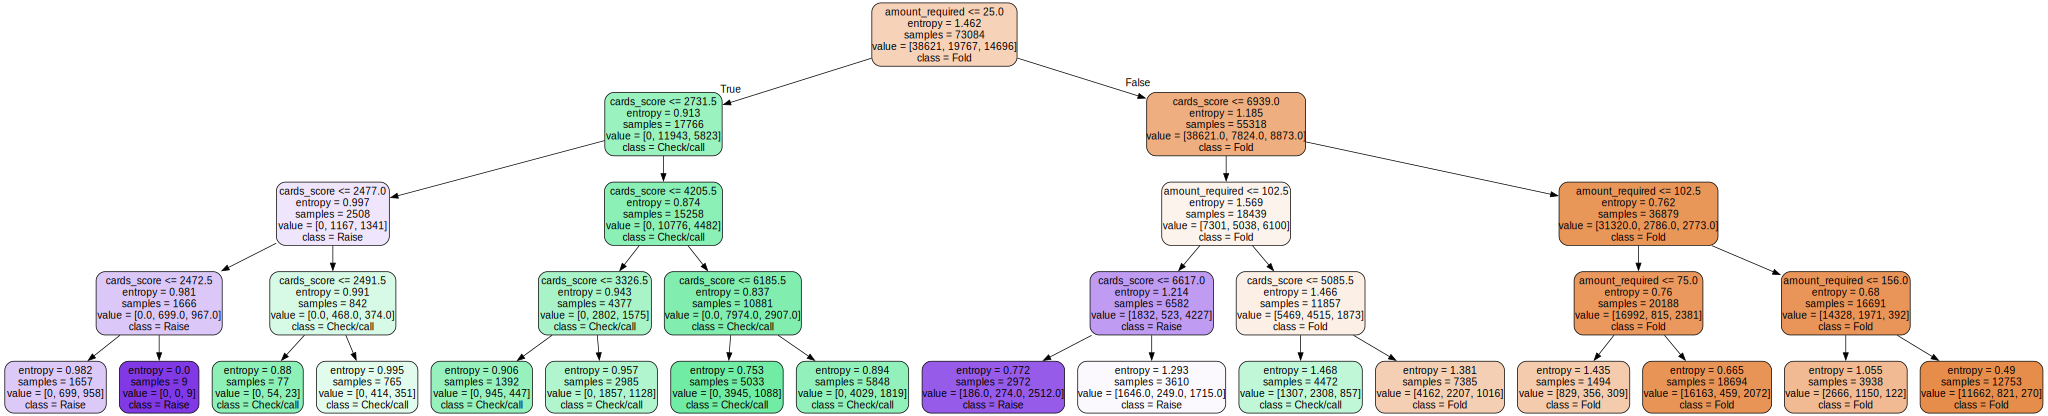

In [7]:
# Show a sisualization of the decision tree in the notebook
viz = export_graphviz(pipelined_model.named_steps['dtc'],feature_names=X_train.columns,class_names=target_labels,rounded=True, filled=True)
graph = graphviz.Source(viz)
graph

In [8]:
# save the visualization as a PNG file and remove the temporary.dot file
viz_for_save = export_graphviz(pipelined_model.named_steps['dtc'],feature_names=X_train.columns,class_names=target_labels,rounded=True, filled=True,
                      out_file = 'Baseline_model_decision_tree.dot')
graph_for_save = graphviz.Source(viz_for_save)

! dot -Tpng Baseline_model_decision_tree.dot -o images/Baseline_modeling/Baseline_model_decision_tree.png
os.remove("Baseline_model_decision_tree.dot")

#### Visualization of the true test dataset

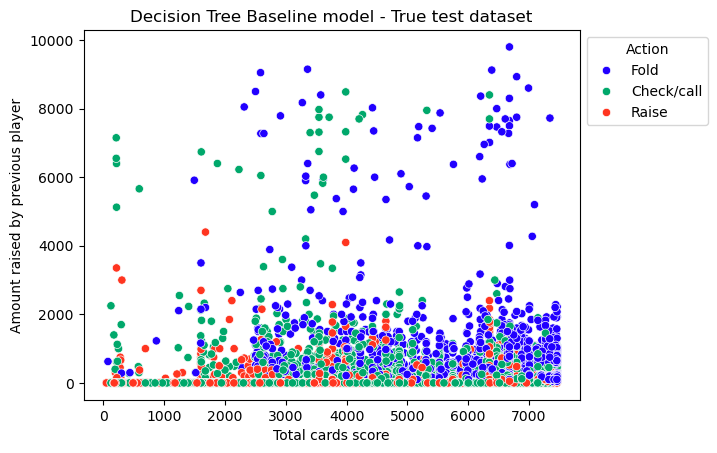

In [9]:
plot = sns.scatterplot(data=X_test, x="cards_score", y="amount_required", hue=y_test, palette=["#2100ff", "#00a86b", "#ff3520"])
# Customize ticks
plt.title("Decision Tree Baseline model - True test dataset")
plt.xlabel("Total cards score")
plt.ylabel("Amount raised by previous player")
sns.move_legend(plot, "upper left", labels=["Fold", "Check/call", "Raise"], bbox_to_anchor=(1, 1), title="Action")
# Save figure to PNG file
plt.savefig('images/Baseline_modeling/Decision Tree Baseline model - True test dataset.png', bbox_inches='tight')
plt.show()

#### Visualization of the predictions for the test dataset

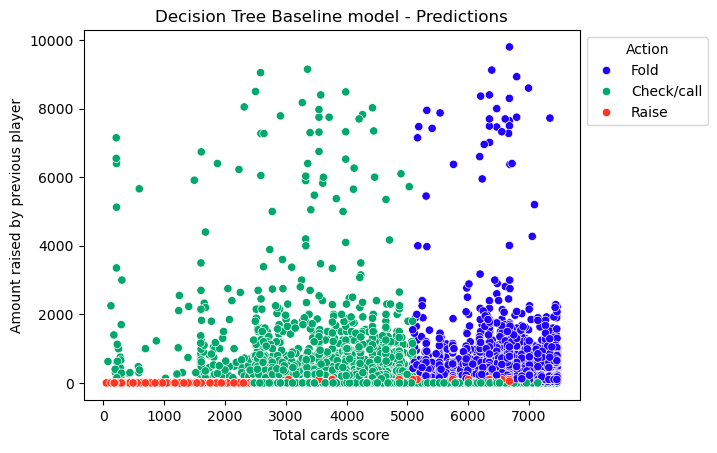

In [10]:
plot = sns.scatterplot(data=X_test, x="cards_score", y="amount_required", hue=y_pred, palette=["#2100ff", "#00a86b", "#ff3520"])
# Customize ticks
plt.title("Decision Tree Baseline model - Predictions")
plt.xlabel("Total cards score")
plt.ylabel("Amount raised by previous player")
sns.move_legend(plot, "upper left", labels=["Fold", "Check/call", "Raise"], bbox_to_anchor=(1, 1), title="Action")
# Save figure to PNG file
plt.savefig('images/Baseline_modeling/Decision Tree Baseline model - Predictions.png', bbox_inches='tight')
plt.show()

#### Visualization of the decision regions

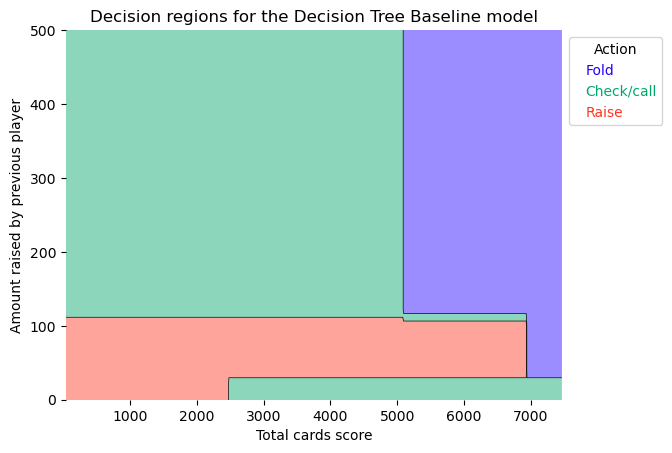

In [11]:
ax = plot_decision_regions(
    X=X_test.values,
    y=y_test.to_numpy(),
    clf=pipelined_model,
    scatter_kwargs={'s': 0},# Hide points by setting size to 0
    colors='#2100ff,#00a86b,#ff3520', legend=False
);
ax.set_ylim(0, 500)
# Customize ticks
plt.title("Decision regions for the Decision Tree Baseline model")
plt.xlabel("Total cards score")
plt.ylabel("Amount raised by previous player")
plt.legend(["Fold", "Check/call", "Raise"], labelcolor=["#2100ff", "#00a86b", "#ff3520"], bbox_to_anchor=(1, 1), handlelength = 0, title = "Action")
plt.savefig('images/Baseline_modeling/Decision regions for the Decision Tree Baseline model.png', bbox_inches='tight')

### Save the Classification model
To reuse the trained model in the future, you should save it.

In [12]:
joblib.dump(pipelined_model, 'models/baseline_classification_model.pkl')

['models/baseline_classification_model.pkl']

## Linear regression model to predict the amount to raise once the action was predicted to be a Raise
For the baseline model, we choose to use a simple Linear regression model to predict the amount to raise once the action was already predicted to be a Raise.

We saw in the exploratory_data_analysis, that the top 3 features are cards_score, amount_required and chen_score. Just like for the above classification model with Decision trees, we will keep only the 2 features cards_score and amount_required as input for a simple baseline model, since the chen_score is a metric a bit redundant from the cards_score.
Also to do the plotting we will keep only the cards_score, so that we can represent in 2D the cards score vs the amount raised by the current player, and show the line of the linear regression model in the same plot

In [90]:
# For this Linear regression model we only need the rows of data which have already been classified as action : Raise
df_r = df[(df['action'] == 'R')]

We can see that the lower the cards score is, the better the hand of the player is, and the higher is the amount that the player is raising

In [145]:
# Simple Linear regression model
X = df_r[['cards_score', 'amount_required']]
y = df_r['amount_raised']

# Divide the dataset into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model: Linear Regression
pipelined_model = Pipeline([
    ('scaler', StandardScaler()),
    ('linear', LinearRegression(fit_intercept = True))
])
pipelined_model.fit(X_train, y_train)

# Evaluate the model
y_pred = pipelined_model.predict(X_test)

### Errors for test data

In [146]:
# Errors for test data
Test_MAE = mean_absolute_error(y_test, y_pred)
Test_RMSE = root_mean_squared_error(y_test, y_pred)
Test_R2_Score = r2_score(y_test, y_pred)

print(Test_MAE, Test_RMSE, Test_R2_Score)

451.8923306791355 947.0337285006657 0.31585732483848805


### Visualizations and plots

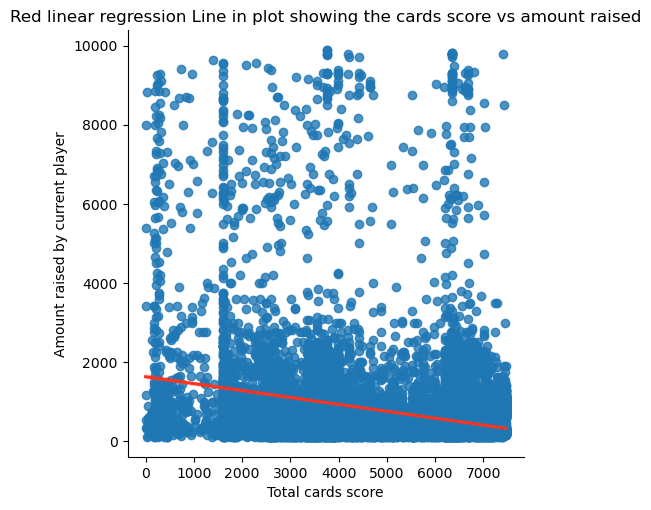

In [177]:
g = sns.lmplot(
    data=df_r,
    x="cards_score", y="amount_raised",
    line_kws={"color": "#ff3520"},  # Set regresion line color to red
    height=5
)
# Use more informative axis labels than are provided by default
g.set_axis_labels("Total cards score", "Amount raised by current player")
plt.title("Red linear regression Line in plot showing the cards score vs amount raised")
# Save figure to PNG file
plt.savefig('images/Baseline_modeling/Red linear regression Line in plot showing the cards score vs amount raised.png', bbox_inches='tight')
plt.show()

### Save the Classification model
To reuse the trained model in the future, you should save it.

In [148]:
joblib.dump(pipelined_model, 'models/baseline_regression_model.pkl')

['models/baseline_regression_model.pkl']

### Create a Function for Predictions
A function to load the saved models and make predictions can streamline future use.

In [173]:
def predict_poker_moves_v1(model_classification_path, model_regression_path, new_data, minimum_bet):
    """
    This function predicts the moves to play in a poker game. It makes 2 predictions:
    - What the player's next action should be (fold, check/call, or raise)
    - In case the action predicted is "raise", it predicts what is the amount to raise
    The function returns a list of list. In each sub-list, there are 2 elements : the action, and the amount to raise
    There is one sub-list for each list provided in the input argument "new_data"
    
    Arguments
    ---------
    model_classification_path: string
           The path of the PKL file of the classification model
    model_regression_path: string
           The path of the PKL file of the regression model
    new_data: List of list
           A list of list. In each sub-list, there should be 2 elements: 
           - the cards_score of the player's hand
           - the amount raised by the previous player. 
           You can calculate the cards_score using function cards_score, which takes in input the list of cards
    minimum_bet: the minimum bet amount set by the poker table

    Returns
    --------
    list_final: List of list
         In each sub-list, there are 2 elements : the action, and the amount to raise
         There is one sub-list for each list provided in the input argument "new_data"
    """
    target_labels_dic = {
        0: 'Fold',
        1: 'Check/call',
        2: 'Raise'
    }
    list_final = []
    # load the models
    model_classification = joblib.load(model_classification_path)
    model_regression = joblib.load(model_regression_path)

    # predict the action first
    list_action_int = model_classification.predict(new_data)

    # predict the raised amount second
    list_raised_amount = model_regression.predict(new_data)

    for n in range(0, len(list_action_int)):
        action = target_labels_dic[list_action_int[n]]
        raise_amount_min_bet_100 = list_raised_amount[n]
        raise_amount = minimum_bet * raise_amount_min_bet_100 / 100
        # if the raise amount is less than the minimum bet it should be equal to minimum bet
        if raise_amount <= minimum_bet:
            raise_amount = minimum_bet
        # if the action is Fold or Check/call, the raise amount should be equal to 0
        if action != 'Raise':
            raise_amount = 0

        list_final.append([action, round(raise_amount, 0)])

    return list_final

### Usage for some quick tests:

We make some quick tests to check if the results provided by our function predict_poker_moves_v1 make sense

In [174]:
new_samples = [[cards_score("7d","2h", "", "", "", "", ""), 100], #7 and 2 which is a bad preflop hand
               [cards_score("As","Ac", "", "", "", "", ""), 100], #Pair of Aces which is a good preflop hand
               [cards_score("2s","2c", "2h", "7d", "Jd", "", ""), 400], #Three of a kind
               [cards_score("Th","Jh","Qh","Kh","Ah", "", ""), 100], # Royal flush which is the best hand possible
               [cards_score("2d","4h", "6s", "8c", "Td", "Qh", "As"), 200]]  # A bad hand with Ace high only
predictions = predict_poker_moves_v1('models/baseline_classification_model.pkl', 'models/baseline_regression_model.pkl', new_samples, 100)
print(predictions)

[['Fold', 0], ['Raise', 993.0], ['Check/call', 0], ['Raise', 1596.0], ['Fold', 0]]


In the test case :
1) with 7 and 2, the predicted action is to Fold which makes sense since it is a bad preflop hand
2) with Pair of Aces, the predicted action is to Raise to 993, which makes sense since it is a good preflop hand
3) with a Three of a kind, the predicted action is to Check/call which is reasonable
4) with a Royal flush which, the predicted action is to Raise to 1596, which makes sense since it is the best hand possible
5) with a bad hand with Ace high only, the predicted action is to Fold which makes sense since it is a bad hand